In [33]:
import logging
import os
import math
import multiprocessing
import json
import re

from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import natsort

In [34]:
use_markers = False
experiment_type = "cv2x"

use_line_types = False
image_format = "png"
figure_store = "../data/figures/"

markers = [".", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+",
           "x", "X", "D", "d", "|", "_", 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

overall_now="12:00:00"
confidence_intervals = False

## Runner for overall job

In [35]:
def generate_graphs(result_folders, now):

    print("Beginning graphing of result file: {}".format(result_folders))

    if not config["processed-result-dir"]:
        config["processed-result-dir"] = prepare_results(result_folders, now)

    for graph_title in results["graph-configurations"]:
        print("Graphing configuration: {}".format(graph_title))
        folders_for_comparison = []
        configurations = []
        for configuration in results["graph-configurations"][graph_title]:
            for folder in config["processed-result-dir"]:
                config_name = folder.split("/")[-1][:-20]
                if configuration == config_name:
                    folders_for_comparison.append(folder)
                    configurations.append(configuration)

        for graph in results["graphs"]:
            if graph in ["PDR-SCI", "PDR-TB", "IPG"]:
                distance_graph(folders_for_comparison, graph, graph_title, configurations, now)
            elif graph == "CBR":
                cbr_graph(folders_for_comparison, graph, graph_title, configurations, now)

## Results Preparation stage

In [36]:
def prepare_results(result_folders, now):

    num_processes = config["parallel_processes"]
    if num_processes > multiprocessing.cpu_count():
        print("Too many processes, going to revert to total - 1")
        num_processes = multiprocessing.cpu_count() - 1

    processed_results = []
    for folder in result_folders:
        config_name = folder.split("/")[-1]
        print("Results for config: {}".format(config_name))
        folder_results = []
        files = natsort.natsorted(os.listdir(folder))
        
        filtered_files = []
        for i in range(len(files)):
            if ".csv" in files[i]:
                filtered_files.append("{}/{}".format(folder, files[i]))

        i = 0
        while i < len(filtered_files):
            if len(filtered_files) < num_processes:
                num_processes = len(filtered_files)
            pool = multiprocessing.Pool(processes=num_processes)

            folder_results.append(pool.starmap(generate_results, zip(filtered_files[i: i + num_processes])))

            pool.close()
            pool.join()

            i += num_processes

        folder_results = [y for x in folder_results for y in x]
        # Go through each of the available stats and write them out to a csv file.
        output_csv_dir = "../data/processed_data/{}/{}-{}".format(experiment_type,
                                                                  config_name, now)

        os.makedirs(output_csv_dir, exist_ok=True)

        # Shortcut ensures we get the stats from the parsed results
        for stat in folder_results[0]:
            if "SCI" in stat:
                across_run_results(folder_results, stat, output_csv_dir, "txRxDistanceSCI")
            elif stat == "CBR":
                across_run_results(folder_results, stat, output_csv_dir, "Time")
            else:
                across_run_results(folder_results, stat, output_csv_dir, "txRxDistanceTB")

        processed_results.append(output_csv_dir)
    return processed_results

In [37]:
def generate_results(output_csv):

    print("Generating results for file: {}".format(output_csv))

    results = {}

    pdr_sci_agg = pd.DataFrame()
    pdr_tb_agg = pd.DataFrame()
    ipg_agg = pd.DataFrame()
    cbr_agg = pd.DataFrame()

    for chunk in pd.read_csv(output_csv, chunksize=10 ** 6):

        # SCI PDR calculation
        pdr_sci_agg = stat_distance(pdr_sci_agg, chunk, "sciDecoded", "txRxDistanceSCI", True)

        # TB PDR calculation
        pdr_tb_agg = stat_distance(pdr_tb_agg, chunk, "tbDecoded", "txRxDistanceTB", True)

        # IPG calculation
        ipg_agg = stat_distance(ipg_agg, chunk, "interPacketDelay", "txRxDistanceTB", False)

        # CBR calculation doesn't aggregate the same way as the above so dealt with separately
        cbr_df = chunk[chunk["cbr"].notnull()]
        cbr_df = cbr_df[["Time", "cbr"]]
        cbr_df = cbr_df.groupby("Time").agg({"cbr": [np.mean, np.std, "count"]})
        cbr_df.columns = cbr_df.columns.droplevel()
        cbr_df = cbr_df.apply(lambda x: x * 100, axis=1)

        if cbr_agg.empty:
            cbr_agg = cbr_df
        else:
            # combine_chunks
            cbr_agg = cbr_agg.append(cbr_df)

    results["PDR-SCI"] = pdr_sci_agg
    results["PDR-TB"] = pdr_tb_agg
    results["IPG"] = ipg_agg
    results["CBR"] = cbr_agg

    return results

In [38]:
def stat_distance(agg_df, df, stat, distance, percentage):

    # Reduce the size of the DF to what we're interested in.
    distance_df = df[df[stat].notnull()]
    distance_df = distance_df[["Time", "NodeID", stat, distance]]
    distance_df = distance_df[distance_df[stat] > -1]

    max_distance = min(510, distance_df[distance].max())

    # Get the mean, std, count for each distance
    distance_df = distance_df.groupby(
        pd.cut(distance_df[distance], np.arange(0, max_distance, 10))).agg(
        {stat: [np.mean, "count"]})

    # Remove over head column
    distance_df.columns = distance_df.columns.droplevel()

    if percentage:
        distance_df = distance_df.apply(lambda x: x * 100, axis=1)

    if agg_df.empty:
        agg_df = distance_df
    else:
        # combine_chunks
        agg_df = pd.merge(agg_df, distance_df, on=distance, how='outer')
        agg_df = agg_df.apply(combine_line, axis=1, result_type='expand')
        agg_df = agg_df.rename({0: "mean", 1: "count"}, axis='columns')

    return agg_df

In [39]:
def combine_line(line):
    mean_a = line["mean_x"]
    count_a = line["count_x"]

    mean_b = line["mean_y"]
    count_b = line["count_y"]

    if np.isnan(mean_a) and np.isnan(mean_b):
        return [mean_a, count_a]
    elif np.isnan(mean_a) and not np.isnan(mean_b):
        return [mean_b, count_b]
    elif np.isnan(mean_b) and not np.isnan(mean_a):
        return [mean_a, count_a]
    else:
        ex_a = mean_a * count_a
        ex_b = mean_b * count_b

        tx = ex_a + ex_b
        tn = count_a + count_b

        overall_mean = tx / tn
        overall_count = tn

        return [overall_mean, overall_count]

In [40]:
def across_run_results(results, stat, output_csv_dir, merge_col):

    df = pd.DataFrame()
    print("Statistic of interest: {}".format(stat))
    for i in range(len(results)):
        if df.empty:
            df = results[i][stat]
        else:
            df = pd.merge(df, results[i][stat], how='outer', on=merge_col,
                          suffixes=(i, i + 1),
                          copy=True, indicator=False)

    mean_cols = df.filter(regex='mean').columns

    n = len(mean_cols) - 1
    t_value = t.ppf(p, n)

    df = df.apply(combine_runs, axis=1, result_type='expand', args=(mean_cols, t_value,))
    df = df.rename({0: "Mean", 1: "Confidence-Interval"}, axis='columns')
    df.to_csv("{}/{}.csv".format(output_csv_dir, stat))

In [41]:
def combine_runs(line, mean_cols, t_value):
    means = []
    for mean in mean_cols:
        means.append(line[mean])

    n = len(means)

    # Average Across runs
    xBar = sum(means) / n

    # Deviation between runs and average
    deviation = []
    for mean in means:
        deviation.append((mean - xBar) ** 2)
    s2 = sum(deviation) / (n - 1)

    # Confidence interval
    ci = t_value * math.sqrt(s2 / n)

    return [xBar, ci]

### Graphing stage

In [42]:
def distance_graph(folders, graph, comparison, configurations, now):
    means = []
    cis = []
    distances = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/{}.csv".format(folder, graph))
        means.append(list(df["Mean"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))
        distances = (list(range(0, df.shape[0] * 10, 10)))

    if graph in ["PDR-SCI", "PDR-TB"]:
        dist_graph(means, distances, configurations,
                   "{}-{}".format(comparison, graph), ylabel="Packet Delivery Rate %", now=now,
                    confidence_intervals=cis, show=False, store=True)
    elif graph == "IPG":
        dist_graph(means, distances, configurations,
                   "{}-{}".format(comparison, graph), ylabel="Inter-Packet Gap (ms)", now=now,
                   legend_pos="upper left", confidence_intervals=cis, show=False, store=True)

In [43]:
def cbr_graph(folders, graph, comparison, configurations, now):
    # Might change this to time based graph but CBR is fine for now
    times = []
    cbr = []
    cis = []
    for folder, config in zip(folders, configurations):
        df = pd.read_csv("{}/CBR.csv".format(folder))
        times.append(list(df["Time"]))
        cbr.append(list(df["Mean"]))
        if confidence_intervals:
            cis.append(list(df["Confidence-Interval"]))

    cbr_plot(cbr, times, "{}-{}".format(comparison, graph), configurations, now=now,
             confidence_intervals=cis, show=False, store=True)

In [44]:
def dist_graph(means, distances, labels, plot_name, ylabel, now, legend_pos="lower left",
               confidence_intervals=None, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(means)):
        if confidence_intervals:
            ax.errorbar(distances, means[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(distances, means[i], label=labels[i])

    ax.set(xlabel='Distance (m)', ylabel=ylabel)
    ax.legend(loc=legend_pos)
    ax.tick_params(direction='in')

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

#     fig.suptitle(plot_name, fontsize=12)

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [45]:
def cbr_plot(cbr, times, plot_name, labels, now, confidence_intervals=None, show=True, store=False):
    fig, ax = plt.subplots()

    for i in range(len(cbr)):
        if confidence_intervals:
            ax.errorbar(times[i], cbr[i], yerr=confidence_intervals[i], label=labels[i])
        else:
            ax.plot(times[i], cbr[i], label=labels[i])

    ax.legend(loc='upper left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))

#     fig.suptitle(plot_name, fontsize=12)

    if show:
        fig.show()

    if store:
        fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [46]:
def errors_dist(distances, decoded, decoded_labels, errors, error_labels, plot_name):
    # TODO: Update to allow such graphing to be automatically configured.

    fig, ax = plt.subplots()

    if use_markers:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i], marker=markers[i], markevery=3)

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j], marker=markers[i + j])

    elif use_line_types:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i])

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j])

    else:
        for i in range(len(decoded)):
            ax.plot(distances, decoded[i], label=decoded_labels[i])

            for j in range(len(errors[i])):
                ax.plot(distances, errors[i][j], label=error_labels[i][j])

    ax.legend(loc='center left')

    ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate (PDR) %')
    ax.grid()

    ax.set_ylim([0, 1])
    plt.yticks(np.arange(0, 1.1, step=.1))

    ax.set_xlim([0, (max(distances) + 1)])
    plt.xticks(np.arange(0, (max(distances) + 1), step=50))

    fig.savefig("{}/{}-{}.png".format(figure_store, plot_name, now), dpi=300)
    plt.close(fig)

In [47]:
config_file = "/Users/brianmccarthy/git_repos/results-analysis/configs/cv2x.json"
with open(config_file) as config_json:
    config = json.load(config_json)[experiment_type]
results = config["results"]
p = results["confidence-interval"]

No handles with labels found to put in legend.


Beginning graphing of result file: []
Graphing configuration: DCC


ValueError: max() arg is an empty sequence

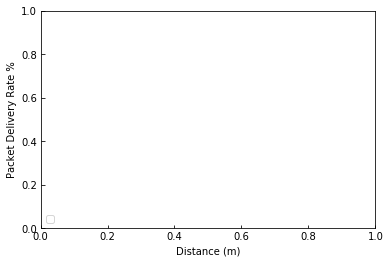

In [48]:
generate_graphs(config["parsed-result-dir"], overall_now)